In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

import numpy as np
import seaborn as sns
import pandas as pd
import wandb

pd.set_option('display.max_columns', None)

In [2]:
api = wandb.Api()
entity, project = "invariance-learners", "icml2024"  # set to your entity and project 

In [3]:
# create dict mapping sweep name to sweep id
sweep_id_dict = {
    "vae_sweep_000_25k_0": "mw5je5vn",
    "vae_sweep_000_50k_0": "elzqyq9c",
    "vae_sweep_180_25k_0": "vse9smaw",
    "vae_sweep_180_50k_0": "1tjwit5m",
    "augvae_sweep_000_25k_0": "chdp68sy",
    "augvae_sweep_000_50k_0": "1ezg8oxd",
    # "augvae_sweep_180_25k_0": "6alcebgm",
    # "augvae_sweep_180_50k_0": "2blyq1cj",
    "augvae_sweep_180_25k_0": "018z820f",
    "augvae_sweep_180_50k_0": "3sv1g1kc",
}

In [4]:
summary_list, config_list, name_list, tags, ids, states, sweeps = [], [], [], [], [], [],  []

for sweep, sweep_id in sweep_id_dict.items():
    runs = api.sweep(entity + "/" + project + "/" + sweep_id).runs

    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

        tags.append(run.tags)

        ids.append(run.id)

        states.append(run.state)

        sweeps.append(sweep)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "tags": tags,
    "id": ids,
    "state": states,
    "sweep": sweeps,
    })

runs_df

,summary,config,name,tags,id,state,sweep
0,"{'test/ll': 845.7672119140625, 'test/x_mse': 0...","{'lr': 0.009, 'seed': 0, 'angle': 0, 'model': ...",earnest-sweep-216,[],ntqg1o32,finished,vae_sweep_000_25k_0
1,"{'β': 1, 'test/elbo': 560.3292236328125, 'trai...","{'lr': 0.009, 'seed': 0, 'angle': 0, 'model': ...",comic-sweep-215,[],im68a2b0,finished,vae_sweep_000_25k_0
2,"{'β': 1, 'test/kld': 68.64752197265625, 'train...","{'lr': 0.009, 'seed': 0, 'angle': 0, 'model': ...",glowing-sweep-214,[],lr87jxqn,finished,vae_sweep_000_25k_0
3,"{'test/kld': 65.7317123413086, 'test/elbo': 87...","{'lr': 0.009, 'seed': 0, 'angle': 0, 'model': ...",dry-sweep-212,[],pfwl5amn,finished,vae_sweep_000_25k_0
4,"{'_step': 10000, '_wandb': {'runtime': 691}, '...","{'lr': 0.009, 'seed': 0, 'angle': 0, 'model': ...",mild-sweep-213,[],plxotvz2,finished,vae_sweep_000_25k_0
...,...,...,...,...,...,...,...
1723,"{'β': 1, '_runtime': 264.6900565624237, 'test/...","{'lr': 0.003, 'seed': 0, 'angle': 180, 'model'...",fanciful-sweep-3,[],25d1fz7b,finished,augvae_sweep_180_50k_0
1724,"{'_step': 10000, 'test/ll': 983.1485595703124,...","{'lr': 0.003, 'seed': 0, 'angle': 180, 'model'...",clean-sweep-4,[],gahvn8og,finished,augvae_sweep_180_50k_0
1725,"{'valid/ll': 957.4700317382812, '_timestamp': ...","{'lr': 0.003, 'seed': 0, 'angle': 180, 'model'...",treasured-sweep-5,[],jhwdh727,finished,augvae_sweep_180_50k_0
1726,"{'_wandb': {'runtime': 293}, 'train/ll': 708.6...","{'lr': 0.003, 'seed': 0, 'angle': 180, 'model'...",smart-sweep-1,[],a1pkikwe,finished,augvae_sweep_180_50k_0


In [5]:
df_expanded = runs_df.join(pd.json_normalize(runs_df['summary'], record_prefix='summary.').add_prefix('summary.')).drop('summary', axis='columns')
df_expanded = df_expanded.join(pd.json_normalize(runs_df['config'], record_prefix='config').add_prefix('config.')).drop('config', axis='columns')

df_expanded.columns

Index(['name', 'tags', 'id', 'state', 'sweep', 'summary.test/ll',
       'summary.test/x_mse', 'summary.train/loss', 'summary.β',
       'summary.test/iwlb',
       ...
       'config.batch_size_eval', 'config.iwlb_num_samples',
       'config.warmup_steps_pct', 'config.shuffle_buffer_size',
       'config.repeat_after_batching', 'config.β_schedule_init_value',
       'config.β_schedule_final_value', 'config.model.conv_dims',
       'config.model.dense_dims', 'config.model.latent_dim'],
      dtype='object', length=103)

In [6]:
# take only completed runs
df_filtered = df_expanded[df_expanded['state'] != 'failed']

# take only runs with certain tags
# tags_to_keep = ['angle_sweep', 'num_trn_sweep', 'mnist', 'vae']
# df_filtered = df_filtered[df_filtered['tags'].apply(lambda x: all(tag in x for tag in tags_to_keep))]

# take only runs without certain tags
# tags_to_remove = ['test', 'hidden', 'ssilvae']
# df_filtered = df_filtered[~df_filtered['tags'].apply(lambda x: any(tag in x for tag in tags_to_remove))]

# replace nans in config.num_trn and config.angle with -1
df_filtered['config.num_trn'] = df_filtered['config.num_trn'].fillna(-1)
df_filtered['config.angle'] = df_filtered['config.angle'].fillna(0)

df_filtered

,name,tags,id,state,sweep,summary.test/ll,summary.test/x_mse,summary.train/loss,summary.β,summary.test/iwlb,summary.valid/loss,summary.lr,summary.valid/ll,summary.valid/kld,summary.train/elbo,summary._runtime,summary.train/kld,summary._timestamp,summary.valid/x_mse,summary.test/kld,summary.train/ll,summary.test/elbo,summary.valid/elbo,summary.valid/iwlb,summary.train/iwlb,summary.train/x_mse,summary._step,summary.test/loss,summary.recon._type,summary.recon.width,summary.recon.format,summary.recon.height,summary.recon.sha256,summary.recon.path,summary.recon.size,summary._wandb.runtime,summary.sample.path,summary.sample.size,summary.sample._type,summary.sample.width,summary.sample.format,summary.sample.height,summary.sample.sha256,summary.gen_plots_1.format,summary.gen_plots_1.height,summary.gen_plots_1.sha256,summary.gen_plots_1.path,summary.gen_plots_1.size,summary.gen_plots_1._type,summary.gen_plots_1.width,summary.inf_plots_0.path,summary.inf_plots_0.size,summary.inf_plots_0._type,summary.inf_plots_0.width,summary.inf_plots_0.format,summary.inf_plots_0.height,summary.inf_plots_0.sha256,summary.gen_plots_0.format,summary.gen_plots_0.height,summary.gen_plots_0.sha256,summary.gen_plots_0.path,summary.gen_plots_0.size,summary.gen_plots_0._type,summary.gen_plots_0.width,summary.inf_plots_1.path,summary.inf_plots_1.size,summary.inf_plots_1._type,summary.inf_plots_1.width,summary.inf_plots_1.format,summary.inf_plots_1.height,summary.inf_plots_1.sha256,config.lr,config.seed,config.angle,config.steps,config.dataset,config.num_trn,config.num_val,config.pp_eval,config.shuffle,config.pp_train,config.run_iwlb,config.clip_norm,config.eval_freq,config.plot_freq,config.val_split,config.batch_size,config.model_name,config.test_split,config.train_split,config.init_lr_mult,config.weight_decay,config.final_lr_mult,config.batch_size_eval,config.iwlb_num_samples,config.warmup_steps_pct,config.shuffle_buffer_size,config.repeat_after_batching,config.β_schedule_init_value,config.β_schedule_final_value,config.model.conv_dims,config.model.dense_dims,config.model.latent_dim
0,earnest-sweep-216,[],ntqg1o32,finished,vae_sweep_000_25k_0,845.767212,0.023712,-1450.412964,1,877.504211,-734.526428,9.000000e-06,803.078064,68.551758,1450.412964,1230.488937,68.514679,1.703099e+09,0.024116,68.025101,1518.928345,777.742004,734.526428,None,None,0.015139,20000,-777.742004,image-file,4000,png,400,76e567ae4faa48c2a12e2181add51bbe9620921c92ee2c...,media/images/recon_19999_76e567ae4faa48c2a12e.png,44664,1255,media/images/sample_19999_4d0268174f0e7c486c15...,41064,image-file,4000,png,200,4d0268174f0e7c486c1596a375f08d2c77c267c2133119...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,0,0,20000,MNIST,25000,10000,"value_range(-1, 1)|random_rotate(-0, 0, fill_v...",preprocessed,"value_range(-1, 1)|random_rotate(-0, 0, fill_v...",False,2,0.01,0.25,train[:10000],512,VAE,test,train[10000:35000],0.03,0.0001,0.0010,50,300,0.25,50000,True,1,1,"64,128,256",256,20
1,comic-sweep-215,[],im68a2b0,finished,vae_sweep_000_25k_0,629.530090,0.024883,-1475.284912,1,689.516663,-464.587036,9.000000e-06,534.447021,69.860168,1475.284912,1251.356825,69.724976,1.703099e+09,0.025315,69.200882,1545.009644,560.329224,464.587036,None,None,0.014550,20000,-560.329224,image-file,4000,png,400,cd8f903f3a246040a3b11f3b0cf42865d7f58c10882702...,media/images/recon_19999_cd8f903f3a246040a3b1.png,44832,1276,media/images/sample_19999_e8e7237063a9f95e506c...,40838,image-file,4000,png,200,e8e7237063a9f95e506ceb215701ed8aebd09776da4410...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,0,0,20000,MNIST,25000,10000,"value_range(-1, 1)|random_rotate(-0, 0, fill_v...",preprocessed,"value_range(-1, 1)|random_rotate(-0, 0, fill_v...",False,2,0.01,0.25,train[:10000],512,VAE,test,train[10000:35000],0.03,0.0001,0.0010,50,300,0.20,50000,True,1,1,"64,128,256",256,20
2,glowing-sweep-214,[

In [7]:
df_filtered['config.angle'].unique()

array([  0, 180])

In [8]:
df_filtered['config.steps'].unique()

array([20000, 10000,  5000])

In [9]:
df_filtered['config.num_trn'].unique()

array([25000, 50000])

In [10]:
df_filtered['config.dataset'].unique()

array(['MNIST'], dtype=object)

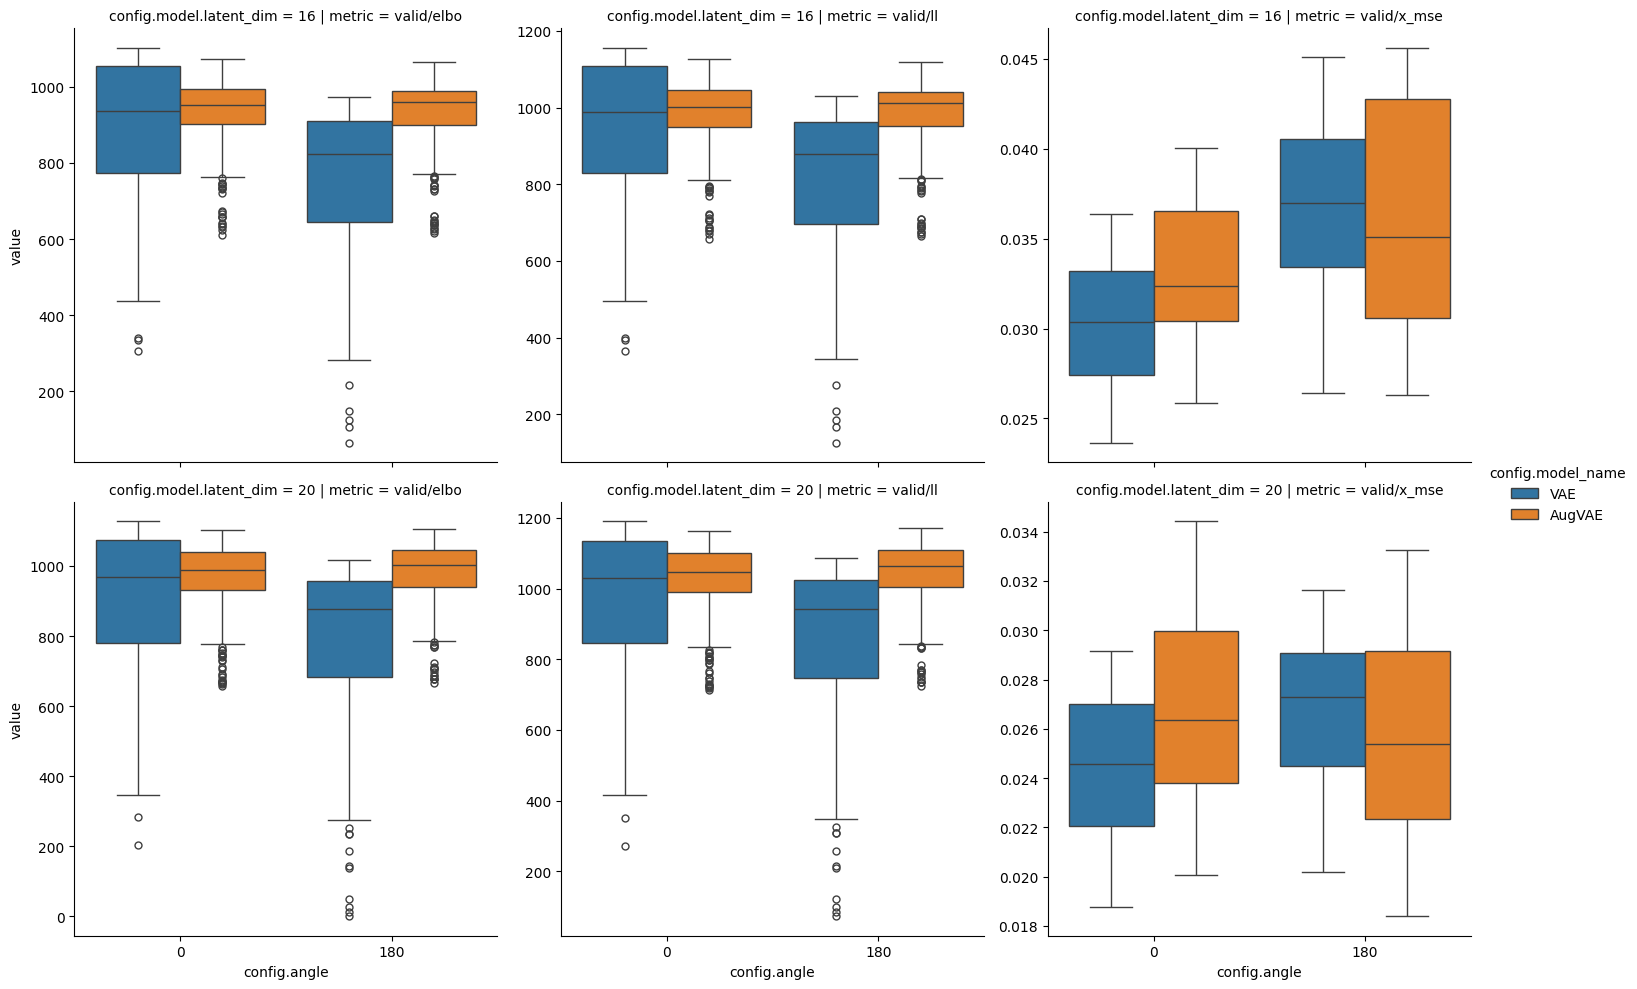

In [11]:
# pivot the data frame so that each of metrics is a column, and the values are the corresponding values
plot_df = df_filtered.melt(
    id_vars=['config.angle', 'config.num_trn', 'config.model_name', 'config.model.latent_dim', 'config.seed'],
    value_vars=['summary.valid/elbo', 'summary.valid/ll', 'summary.valid/x_mse'],
    var_name='metric',
    value_name='value'
)

# remove the 'summary.' prefix from the metric names
plot_df['metric'] = plot_df['metric'].str.replace('summary.', '')


sns.catplot(data=plot_df, x="config.angle", y="value", col="metric", row='config.model.latent_dim', hue='config.model_name', kind="box", showfliers=True, sharey=False)

In [12]:
df = df_filtered.sort_values(
    by='summary.valid/elbo', ascending=False).groupby(
        ['config.angle', 'config.num_trn', 'config.model_name', 'config.seed',])[
    ['summary.valid/elbo', 'summary.valid/ll', 'summary.valid/x_mse']].first()
df

summary.valid/elbo  \
config.angle config.num_trn config.model_name config.seed                       
0            25000          AugVAE            0                   1088.689941   
                            VAE               0                   1019.709778   
             50000          AugVAE            0                   1102.393311   
                            VAE               0                   1127.443848   
180          25000          AugVAE            0                   1095.644653   
                            VAE               0                    894.520142   
             50000          AugVAE            0                   1106.173706   
                            VAE               0                   1016.751465   

                                                           summary.valid/ll  \
config.angle config.num_trn config.model_name config.seed                     
0            25000          AugVAE            0                 1148.802979   
                            VAE               0                 1079.483398   
             50000          AugVAE            0                 1162.385620   
                            VAE               0                 1189.972900   
180          25000          AugVAE            0                 1161.154175   
                            VAE               0                  957.042236   
             50000          AugVAE            0                 1172.050659   
                            VAE               0                 1086.015625   

                                                           summary.valid/x_mse  
config.angle config.num_trn config.model_name config.seed                       
0            25000          AugVAE            0                       0.024421  
                            VAE               0                       0.027829  
             50000          AugVAE            0                       0.023624  
                            VAE               0                       0.026996  
180          25000          AugVAE            0                       0.019758  
                            VAE               0                       0.029696  
             50000          AugVAE            0                       0.020442  
                            VAE               0                       0.024213

<Axes: xlabel='config.angle', ylabel='summary.valid/elbo'>

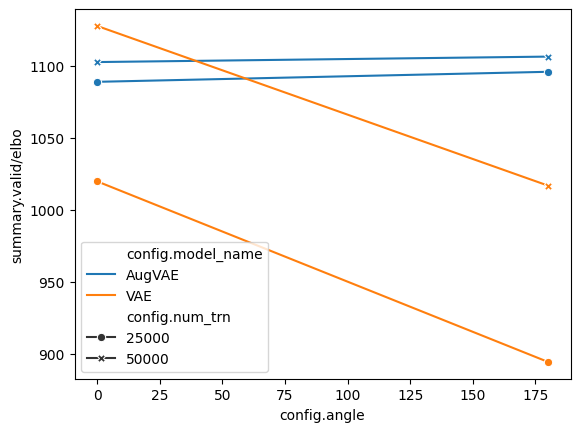

In [13]:
sns.lineplot(data=df.reset_index(), x="config.angle", y="summary.valid/elbo", hue='config.model_name', style='config.num_trn', markers=True, dashes=False)